# Генерация коротких текстов с помощью RNN


Генерировать тексты можно с помощью RNN, предсказывающей следующий символ последовательности по предыдущим.

В этом задании предлагается написать и проучить на небольшом датасете имен [генеративную модель на основе символов -- Char-RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

![charseq](./charseq.jpeg)
Картинка взята из [статьи Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

В файле `names` находится ~8k имен на латинице.

Модель будет получать на вход имя `Amandy` и выдавать его же, только со сдвигом: `mandy `.

Чтобы сеть училась генерировать заглавные буквы, добавим в начало специальный токен, пробел:
```
_Amandy --> Amandy_
```

Для практического использования, на каждом шаге будем подавать на вход букву, предсказанную на предыдущем.
Так что нам потребуется правило для останова генерации (это может быть просто ограничение на количество шагов).
С другой стороны, можно добавить в конец каждого примера обучающей выборки специальный `<EOS>` токен. В данном случае обозначим его `#`:

```
_Amandy --> Amandy#
```

Будем прекращать генерацию при досрочном выпадании `<EOS>`.

In [2]:
import os
start_token = " "
eos = '#'

with open("names") as f:
    names = f.readlines()
    names = [start_token + name.strip() + eos for name in names]

names = list(set(names))  # в датасете есть повторы
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7578 names: 
 Collin#
 Priscella#
 Claribel#
 Chloette#
 Katey#
 Margareta#
 Gilberte#
 Mohamed#


In [3]:
from collections import defaultdict
import string

defaultdict(<class 'int'>, {'c': 1264, 'o': 2207, 'l': 3608, 'i': 4041, 'n': 3932, 's': 1922, 'h': 1343, 'e': 5873, 'a': 6049, 'm': 1366, 'y': 1305, 'x': 69, 'd': 1679, 'r': 3709, 't': 2178, 'g': 756, 'p': 409, 'w': 347, 'f': 440, 'u': 805, 'b': 904, 'k': 625, 'z': 176, 'j': 459, 'v': 465, 'q': 57})


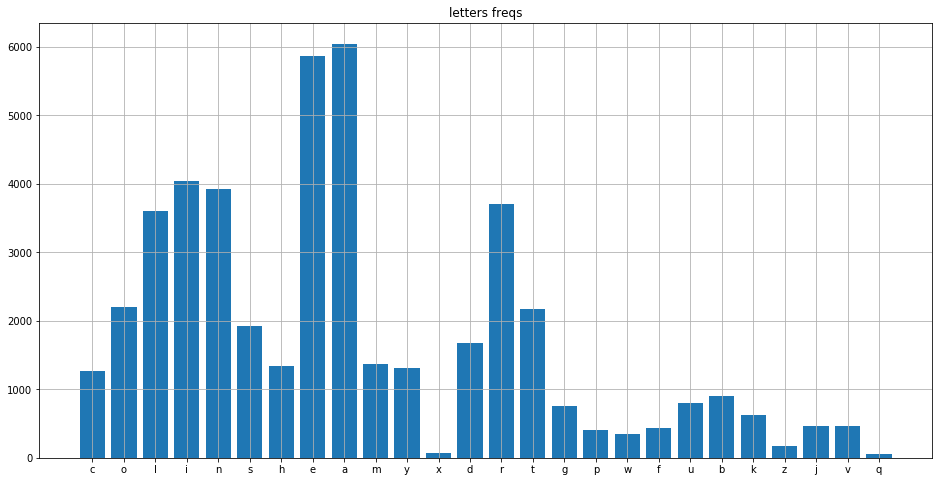

In [4]:
# TODO: постройте частоты употреблений букв
# <your code>
freqs = defaultdict(int)

for name in names:
    for symbol in name:
        if symbol in set(string.ascii_letters):
            freqs[symbol.lower()] += 1
# HINT: для графика возьмите plt.bar

print(freqs)
plt.figure(figsize=(16, 8))
plt.title('letters freqs')
plt.bar(freqs.keys(), freqs.values())
plt.grid()

max length = 17


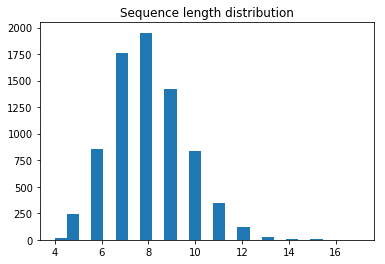

In [5]:
# датасете есть слова с разными длинами
MAX_LENGTH = max(map(len,names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [6]:
names[:10]

[' Collin#',
 ' Lishe#',
 ' Naoma#',
 ' Sloan#',
 ' Holly#',
 ' Maxy#',
 ' Dorit#',
 ' Glenna#',
 ' Alpa#',
 ' Wolfy#']

In [7]:
# TODO: отберите уникальные токены и заполните два словаря для конвертации токенов <-> индексы
# сделайте так, чтобы пробел имел номер 0
    
tokens = sorted(list(set.union(*[set(name) for name in names])))

tok2id = dict(zip(tokens, np.arange(len(tokens))))
id2tok = dict(enumerate(tokens))

n_tokens = len(tokens)
print (f'There are {n_tokens} tokens')

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 56 tokens
Vocabular:  #'-ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [8]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [9]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

 Collin#
 Lishe#
 Naoma#
 Sloan#
 Holly#
 Maxy#
 Dorit#
 Glenna#
 Alpa#
 Wolfy#
[[ 0  6 44 41 41 38 43  1]
 [ 0 15 38 48 37 34  1  0]
 [ 0 17 30 44 42 30  1  0]
 [ 0 22 41 44 30 43  1  0]
 [ 0 11 44 41 41 54  1  0]
 [ 0 16 30 53 54  1  0  0]
 [ 0  7 44 47 38 49  1  0]
 [ 0 10 41 34 43 43 30  1]
 [ 0  4 41 45 30  1  0  0]
 [ 0 26 44 41 35 54  1  0]]


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# TODO: разбейте все имена на тренировочную (80%) и тестовую часть (20%)
# <your code>
split_data = lambda x : train_test_split(x, test_size=0.2)

train_data, val_data = split_data(names)

len(train_data), len(val_data)

(6062, 1516)

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

# Char-RNN для имен (0.2 балла)

Вам нужно написать сеть, кодирующую номера входных символов с помощью таблицы Embeddings. 
Получившиеся тензоры пропустить через RNN ячейку, затем преобразовать в логиты для предсказания номера нового символа.

In [13]:
# NB: обратите внимание на порядок осей при вызове forward
# http://pytorch.org/docs/master/nn.html#recurrent-layers

# Сделайте возможность выбора типа ячейки, RNN, GRU или LSTM
# TODO: заполните пропуски. Функция forward будет вызываться на каждый шаг нами

class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, cell="rnn", n_layers=1):
        super(NameRNN, self).__init__()
        # добавьте возможность выбрать тип ячейки RNN/LSTM
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.cell = cell
        
#         <your code>

        self.encoder = nn.Embedding(vocab_size, hidden_size)

        if self.cell == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, batch_first=True)
        elif self.cell == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True)
        elif self.cell == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
            
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
#         print(input.shape)
#         input = torch.from_numpy(input)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
#         print(output.shape)
        output = self.decoder(output)
        
        return output, hidden

    def init_hidden(self, batch_size):
        if self.cell == "lstm":
            return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True))
        
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True)

# Код для тренировки RNN (0.2 балла)

In [14]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()
    
    for batch in train_batches:
        # можно вынести подсчет ошибки в модельку
        
        nums = torch.from_numpy(to_matrix(batch))
#         <your code>

        optimizer.zero_grad()
        output, _ = model(nums[:, :-1], model.init_hidden(nums.shape[0]))
        
        criterion = nn.CrossEntropyLoss()
#         print(output.view(-1, output.size(2)), output.view(-1, output.size(2)).shape)
#         print(nums[:, 1:].contiguous().view(-1), nums[:, 1:].contiguous().view(-1).shape)
        
        loss = criterion(output.view(-1, output.size(2)), nums[:, 1:].contiguous().view(-1))
        
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
        loss_log.append(loss)
    return loss_log   

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:  
        
        nums = torch.from_numpy(to_matrix(batch))
#         <your code>
        
        output, _ = model(nums[:, :-1], model.init_hidden(nums.shape[0]))
        
        criterion = nn.CrossEntropyLoss()

        loss = criterion(output.view(-1, output.size(2)), nums[:, 1:].contiguous().view(-1))
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)
        
        val_loss = test(model, test_batches)
        train_log.extend(train_loss)
        
        val_log.append((len(train_log), np.mean(val_loss)))
        
        clear_output()
        plot_history(train_log, val_log)

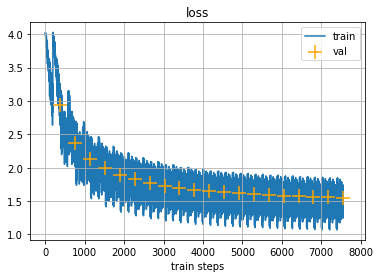

In [15]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='rnn')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

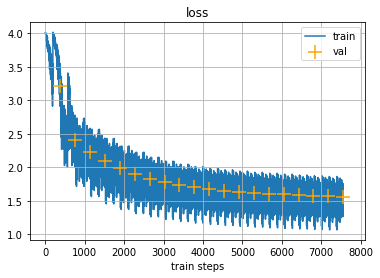

In [16]:
rnn = NameRNN(len(tokens), 50, len(tokens), cell='lstm')

opt = torch.optim.Adam(rnn.parameters(), lr=1e-4)
train(rnn, opt, 20)

# Генерация по argmax (0.2 балла)

In [17]:
# Напишите функцию генерации продолжения строки
def pick_by_argmax(logits):
#     <your code>
    return torch.argmax(logits, dim=-1)
    

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix=" ", limit=15):
    hidden = model.init_hidden(1)
    nums = to_matrix([prefix])
    nums = torch.from_numpy(nums)
    
    # TODO: сначала сверните строку с помощью RNN:
    # нас интересует последний output и hidden
#     <your code>
    model.eval()
    
    # TODO: затем сгенерируйте несколько последующих символов
    # outs -- это массив с номерами токенов
#     <your code>

    outs = ""
    i = 1
    
    while not outs.endswith('#') and i < limit:
        output, _ = model(nums, hidden)
        nums = torch.cat([nums, pick_by_argmax(output[:, -1]).view(1, -1)], -1)
        i += 1
        outs = ids2string(nums.numpy()[:, len(prefix) - 1:].tolist()[0])
    
    print(f'{prefix}|{outs}')
gen_continuation(rnn, " Ku")

 Ku|ulin#


# Генерация с семплированием (0.4 балла)

Обычный софтмакс 
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
можно модернизировать с помощью температуры:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

Это позволит плавно переходить от выбора наиболее вероятного элемента ($T << 1$) до практически равновероятного ($T >> 1$)


In [18]:
# Напишите функцию генерации батчами с семплированием из распределения и температурой
def batch2string(ids, prefix):
    # модифицируйте ids2string для работы с батчами
#     <your code>
    return ([f'{prefix}|{ids2string(id)}' for id in ids])

def pick_by_distribution(logits):
    # превратите логиты в распределение
    # затем семлируйте из него batch примеров
#     <your code>
    return [np.random.choice(range(len(part)), p=F.softmax(torch.FloatTensor(part), -1).detach().numpy())
            for part in logits]


def gen_continuation_temp(model, prefix=" ", temperature=1.0, n=10):
    hidden = model.init_hidden(n)
    nums = to_matrix([prefix] * n)
    nums = torch.from_numpy(nums)

    # аналогично, сначала получите батч output, hidden
    model.eval()
    
    # затем, сгенерируйте n последующих символов
    # в outs положите матрицу номеров токенов и отобразите ее
    
    outs = ""
    
    while not np.any(np.array(["#" in s for s in outs])):
        output, _ = model(nums, hidden)
#         print(torch.LongTensor(pick_by_distribution(output[:, -1])).view(n, -1))
#         print(nums)
        nums = torch.cat((nums, torch.LongTensor(pick_by_distribution(output[:, -1] / temperature)).view(n, -1)), 1)
        outs = batch2string(nums.numpy()[:, len(prefix) - 1:].tolist(), prefix)
#         print(nums.numpy()[:, len(prefix) - 1:].tolist()[0])
#         print(np.array(outs))
        
    print(outs)

In [20]:
gen_continuation_temp(rnn, prefix=" eclaire", temperature=0.5, n=10)

[' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#', ' eclaire|e#']
